<a href="https://colab.research.google.com/github/MartynaPlomecka/AI4Health/blob/main/martyna_stats_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dependencies

In [ ]:
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install sktime
!{sys.executable} -m pip install catboost
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
from pathlib import Path
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sktime
from sktime.pipeline import make_pipeline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.segment import IntervalSegmenter
from sktime.transformations.series.exponent import ExponentTransformer
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.datatypes import check_raise
from google.colab import drive
import ast
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")





# Preprocessing

In [ ]:
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/ETRA-Data/data/outfiles'  
files = Path(path).glob('*.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Concat all dfs with filename as a column:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    data['time_like'] = range(1, len(data) + 1)
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [ ]:
# drop samples with eyes closed
df = df.drop(df[df.left_pupil_validity == 0].index)
df = df.drop(df[df.right_pupil_validity == 0].index)

In [ ]:
df

,Unnamed: 0,system_time_stamp,time_gaze,left_gaze_point_on_display_area_x,left_gaze_point_on_display_area_y,left_pupil_validity,right_gaze_point_on_display_area_x,right_gaze_point_on_display_area_y,right_pupil_validity,system_time_stamp_lag_gaze,...,final_switch,final_switch_fill,switch_point_lag,switch_point,system_time_stamp_lag_switch,switch_monotonic,system_time_stamp_diff,buffering_test,file,time_like
0,0,6.079440e+08,13:35:04:474,0.502182,0.540353,1,0.502810,0.475850,1,6.079440e+08,...,0.0,0.0,0.0,0,6.079437e+08,0,NaN,normal,ZE49_man,1
1,1,6.079440e+08,13:35:04:478,0.507260,0.470399,1,0.493206,0.530750,1,6.079440e+08,...,0.0,0.0,0.0,0,6.079437e+08,0,4.000,normal,ZE49_man,2
2,2,6.079440e+08,13:35:04:482,0.508317,0.562755,1,0.527488,0.684931,1,6.079440e+08,...,0.0,0.0,0.0,0,6.079437e+08,0,4.001,normal,ZE49_man,3
37,37,6.079441e+08,13:35:04:624,0.602979,0.526888,1,0.612597,0.535492,1,6.079441e+08,...,0.0,0.0,0.0,0,6.079437e+08,0,4.001,normal,ZE49_man,38
38,38,6.079441e+08,13:35:04:628,0.601924,0.434036,1,0.609942,0.461096,1,6.079441e+08,...,0.0,0.0,0.0,0,6.079437e+08,0,4.000,normal,ZE49_man,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028958,47284,5.219557e+06,14:25:40:340,0.100056,0.339831,1,0.154996,0.207174,1,5.219553e+06,...,0.0,1.0,1.0,0,5.219548e+06,0,4.002,normal,ZN8_woman,47285
5028960,47286,5.219565e+06,14:25:40:347,0.089198,0.321655,1,0.095982,0.354031,1,5.219561e+06,...,0.0,1.0,1.0,0,5.219556e+06,0,4.000,normal,ZN8_woman,47287
5028962,47288,5.219573e+06,14:25:40:356,0.163295,0.339731,1,0.172254,0.233562,1,5.219569e+06,...,0.0,1.0,1.0,0,5.219564e+06,0,4.000,normal,ZN8_woman,47289
5028963,47289,5.219577e+06,14:25:40:360,0.094622,0.336422,1,0.136100,0.423013,1,5.219573e+06,...,0.0,1.0,1.0,0,5.219572e+06,0,4.002,normal,ZN8_woman,47290


In [ ]:
# Drop all unnecessary columns:
df.drop(columns=["time_gaze",
       'system_time_stamp_lag_gaze', 'gaze_monotonic', 'Unnamed: 0','Unnamed: 0.1',
       'time_switch', 'msg', 'mouse_clicks', 'click_coords', 'final_switch',
        'switch_point_lag',
       'system_time_stamp_lag_switch', 'switch_monotonic', 'buffering_test','left_pupil_validity','right_pupil_validity', 'system_time_stamp_diff','right_gaze_point_on_display_area_x','right_gaze_point_on_display_area_y'],inplace=True)

In [ ]:
# Set index as timelike thing:
# rmoving blink gaps:
df = df.reset_index(drop=True)
df['time_like'] = df.index

In [ ]:
# Seperate sbj and trial:
df['sbj'], df['trial'] = df['file'].str.split('_', 1).str

<ipython-input-99-3f4bc354ebf5>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['sbj'], df['trial'] = df['file'].str.split('_', 1).str


In [ ]:
# task with man = 1, task with woman = 2:
df.loc[df['trial'] == 'man', 'task'] = 1
df.loc[df['trial'] == 'Man', 'task'] = 1
df.loc[df['trial'] == 'woman', 'task'] = 2
df.loc[df['trial'] == 'Woman', 'task'] = 2
df['task'] = pd.to_numeric(df['task'])
df.head()

,system_time_stamp,left_gaze_point_on_display_area_x,left_gaze_point_on_display_area_y,final_switch_fill,switch_point,file,time_like,sbj,trial,task
0,6.079440e+08,0.502182,0.540353,0.0,0,ZE49_man,0,ZE49,man,1.0
1,6.079440e+08,0.507260,0.470399,0.0,0,ZE49_man,1,ZE49,man,1.0
2,6.079440e+08,0.508317,0.562755,0.0,0,ZE49_man,2,ZE49,man,1.0
3,6.079441e+08,0.602979,0.526888,0.0,0,ZE49_man,3,ZE49,man,1.0
4,6.079441e+08,0.601924,0.434036,0.0,0,ZE49_man,4,ZE49,man,1.0


In [ ]:
df.tail()

,system_time_stamp,left_gaze_point_on_display_area_x,left_gaze_point_on_display_area_y,final_switch_fill,switch_point,file,time_like,sbj,trial,task
3536419,5219557.272,0.100056,0.339831,1.0,0,ZN8_woman,3536419,ZN8,woman,2.0
3536420,5219565.270,0.089198,0.321655,1.0,0,ZN8_woman,3536420,ZN8,woman,2.0
3536421,5219573.270,0.163295,0.339731,1.0,0,ZN8_woman,3536421,ZN8,woman,2.0
3536422,5219577.272,0.094622,0.336422,1.0,0,ZN8_woman,3536422,ZN8,woman,2.0
3536423,5219597.269,0.105475,0.358369,1.0,0,ZN8_woman,3536423,ZN8,woman,2.0


In [ ]:

# load the template matched precomputed timepoints:
labels_switches = pd.read_csv(r'/content/drive/MyDrive/ETRA-Data/template_matched.csv')
# Seperate sbj and trial:
labels_switches['sbj'], labels_switches['trial'], _, _ = labels_switches['name'].str.split('_').str
# labels_switches.drop(columns=['name'],inplace=True)


<ipython-input-102-962561028342>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  labels_switches['sbj'], labels_switches['trial'], _, _ = labels_switches['name'].str.split('_').str


In [ ]:
labels_switches


,name,09_fps,10_fps,11_fps,gaze_length,most similar vid length,shortest distance,is_video_shorter,switches_to_video,frames_total,switches_back,sbj,trial
0,ZE14_man_2022-08-10_13h14.05.398.avi,174.000000,156.6,142.363636,146.44,142.36,4.08,yes,[413],1565,[428],ZE14,man
1,ZE14_woman_2022-08-10_13h17.54.923.avi,226.666667,204.0,185.454545,201.69,204.00,2.31,no,[],2039,[],ZE14,woman
2,ZE16_man_2022-07-27_10h45.25.687.avi,166.111111,149.5,135.909091,152.89,149.50,3.39,yes,[325],1494,[345],ZE16,man
3,ZE16_woman_2022-07-27_10h49.35.870.avi,176.444444,158.8,144.363636,176.68,176.44,0.24,yes,[],1587,[],ZE16,woman
4,ZE18_man_2022-07-26_11h42.09.353.avi,129.666667,116.7,106.090909,129.35,129.67,0.32,no,[55],1166,[113],ZE18,man
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,ZN60_man_2022-07-07_20h57.53.698.avi,164.444444,148.0,134.545455,127.65,134.55,6.90,no,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man
89,ZN7_man_2022-06-24_15h56.45.248.avi,364.555556,328.1,298.272727,294.87,298.27,3.40,no,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man
90,ZN7_woman_2022-06-24_16h03.58.687.avi,252.444444,227.2,206.545455,273.36,252.44,20.92,yes,[],2271,[],ZN7,woman
91,ZN8_man_2022-07-08_14h09.50.629.avi,458.444444,412.6,375.090909,406.25,412.60,6.35,no,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man


In [ ]:
# Estimate the timepoints of switches
def estimate(row):
  switches = ast.literal_eval(row.switches_to_video)
  estimated = []
  for element in switches:
    estimated.append(element/row.frames_total*row.gaze_length)
  return str(estimated)
labels_switches["estimated_times_of_switch"] = labels_switches.apply(lambda row: estimate(row), axis=1)
labels_switches["sbj"], labels_switches["trial"], _, _ = labels_switches["name"].str.split("_").str
labels_switches["file"] =  labels_switches["sbj"] + "_" + labels_switches["trial"]
labels_switches.drop(columns=["09_fps", "10_fps", "11_fps", "most similar vid length", "shortest distance", "is_video_shorter", "name"],inplace=True)
labels_switches.head()

<ipython-input-104-702498c002ea>:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  labels_switches["sbj"], labels_switches["trial"], _, _ = labels_switches["name"].str.split("_").str


,gaze_length,switches_to_video,frames_total,switches_back,sbj,trial,estimated_times_of_switch,file
0,146.44,[413],1565,[428],ZE14,man,[38.645188498402554],ZE14_man
1,201.69,[],2039,[],ZE14,woman,[],ZE14_woman
2,152.89,[325],1494,[345],ZE16,man,[33.25920348058902],ZE16_man
3,176.68,[],1587,[],ZE16,woman,[],ZE16_woman
4,129.35,[55],1166,[113],ZE18,man,[6.101415094339623],ZE18_man


In [ ]:
labels_scores = pd.read_csv('/content/drive/MyDrive/ETRA-Data/scores_binary.csv')
labels_scores.head()

labels_scores_man = labels_scores.copy()
labels_scores_woman = labels_scores.copy()

labels_scores_man["file"] = labels_scores_man["sbj"] + "_man"
labels_scores_man["score"] = labels_scores_man["man"]
labels_scores_man.drop(columns=['man', "woman", "total"],inplace=True)
labels_scores_woman["file"] = labels_scores_woman["sbj"] + "_woman"
labels_scores_woman["score"] = labels_scores_woman["woman"]
labels_scores_woman.drop(columns=['man', "woman", "total"],inplace=True)

labels_scores = pd.concat([labels_scores_man, labels_scores_woman])

In [ ]:
labels_scores

,sbj,score,pass_fail,file
0,ZE14,3,1,ZE14_man
1,ZE16,4,1,ZE16_man
2,ZE18,2,0,ZE18_man
3,ZE49,2,0,ZE49_man
4,ZE59,4,1,ZE59_man
...,...,...,...,...
46,ZN53,4,1,ZN53_woman
47,ZN54,2,0,ZN54_woman
48,ZN55,3,0,ZN55_woman
49,ZN59,2,0,ZN59_woman



# Statistics

In the previous parts we have loaded all data and their preprocessing steps that we need to run our tasks. Before running our tasks we can use this section, to create some interesting statistics that can be used for shaping and making decisions for our experiments.

In [ ]:
my_lists = [ast.literal_eval(labels_switches["switches_to_video"][i]) for i in range(len(labels_switches.index))]
total = sum(len(l) for l in my_lists)
print(f"We have in total in all the datasets: {total} switches")

We have in total in all the datasets: 416 switches


In [ ]:
labels_switches["switches_listformat"] = my_lists
labels_switches = pd.DataFrame(labels_switches)
labels_switches

,gaze_length,switches_to_video,frames_total,switches_back,sbj,trial,estimated_times_of_switch,file,switches_listformat
0,146.44,[413],1565,[428],ZE14,man,[38.645188498402554],ZE14_man,[413]
1,201.69,[],2039,[],ZE14,woman,[],ZE14_woman,[]
2,152.89,[325],1494,[345],ZE16,man,[33.25920348058902],ZE16_man,[325]
3,176.68,[],1587,[],ZE16,woman,[],ZE16_woman,[]
4,129.35,[55],1166,[113],ZE18,man,[6.101415094339623],ZE18_man,[55]
...,...,...,...,...,...,...,...,...,...
88,127.65,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[13.636713995943206, 32.27931034482759, 52.389...",ZN60_man,"[158, 374, 607, 1145]"
89,294.87,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[71.29021646341464, 115.61061585365854, 167.84...",ZN7_man,"[793, 1286, 1867, 2736]"
90,273.36,[],2271,[],ZN7,woman,[],ZN7_woman,[]
91,406.25,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[22.159090909090907, 24.03030303030303, 44.318...",ZN8_man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2..."


In [ ]:
#amount of switches
labels_switches['number'] = labels_switches.switches_listformat.map(len)
labels_switches

,gaze_length,switches_to_video,frames_total,switches_back,sbj,trial,estimated_times_of_switch,file,switches_listformat,number
0,146.44,[413],1565,[428],ZE14,man,[38.645188498402554],ZE14_man,[413],1
1,201.69,[],2039,[],ZE14,woman,[],ZE14_woman,[],0
2,152.89,[325],1494,[345],ZE16,man,[33.25920348058902],ZE16_man,[325],1
3,176.68,[],1587,[],ZE16,woman,[],ZE16_woman,[],0
4,129.35,[55],1166,[113],ZE18,man,[6.101415094339623],ZE18_man,[55],1
...,...,...,...,...,...,...,...,...,...,...
88,127.65,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[13.636713995943206, 32.27931034482759, 52.389...",ZN60_man,"[158, 374, 607, 1145]",4
89,294.87,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[71.29021646341464, 115.61061585365854, 167.84...",ZN7_man,"[793, 1286, 1867, 2736]",4
90,273.36,[],2271,[],ZN7,woman,[],ZN7_woman,[],0
91,406.25,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[22.159090909090907, 24.03030303030303, 44.318...",ZN8_man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12


In [ ]:
data = labels_switches 
data

,gaze_length,switches_to_video,frames_total,switches_back,sbj,trial,estimated_times_of_switch,file,switches_listformat,number
0,146.44,[413],1565,[428],ZE14,man,[38.645188498402554],ZE14_man,[413],1
1,201.69,[],2039,[],ZE14,woman,[],ZE14_woman,[],0
2,152.89,[325],1494,[345],ZE16,man,[33.25920348058902],ZE16_man,[325],1
3,176.68,[],1587,[],ZE16,woman,[],ZE16_woman,[],0
4,129.35,[55],1166,[113],ZE18,man,[6.101415094339623],ZE18_man,[55],1
...,...,...,...,...,...,...,...,...,...,...
88,127.65,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[13.636713995943206, 32.27931034482759, 52.389...",ZN60_man,"[158, 374, 607, 1145]",4
89,294.87,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[71.29021646341464, 115.61061585365854, 167.84...",ZN7_man,"[793, 1286, 1867, 2736]",4
90,273.36,[],2271,[],ZN7,woman,[],ZN7_woman,[],0
91,406.25,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[22.159090909090907, 24.03030303030303, 44.318...",ZN8_man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12


In [ ]:
data['task'] = data['trial'].replace(['man', 'Man','woman', 'Woman'], ['1','1','2','2'])
data['task'] = data['task'].astype(int)
data = pd.DataFrame(data)

In [ ]:
data

,gaze_length,switches_to_video,frames_total,switches_back,sbj,trial,estimated_times_of_switch,file,switches_listformat,number,task
0,146.44,[413],1565,[428],ZE14,man,[38.645188498402554],ZE14_man,[413],1,1
1,201.69,[],2039,[],ZE14,woman,[],ZE14_woman,[],0,2
2,152.89,[325],1494,[345],ZE16,man,[33.25920348058902],ZE16_man,[325],1,1
3,176.68,[],1587,[],ZE16,woman,[],ZE16_woman,[],0,2
4,129.35,[55],1166,[113],ZE18,man,[6.101415094339623],ZE18_man,[55],1,1
...,...,...,...,...,...,...,...,...,...,...,...
88,127.65,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[13.636713995943206, 32.27931034482759, 52.389...",ZN60_man,"[158, 374, 607, 1145]",4,1
89,294.87,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[71.29021646341464, 115.61061585365854, 167.84...",ZN7_man,"[793, 1286, 1867, 2736]",4,1
90,273.36,[],2271,[],ZN7,woman,[],ZN7_woman,[],0,2
91,406.25,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[22.159090909090907, 24.03030303030303, 44.318...",ZN8_man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12,1


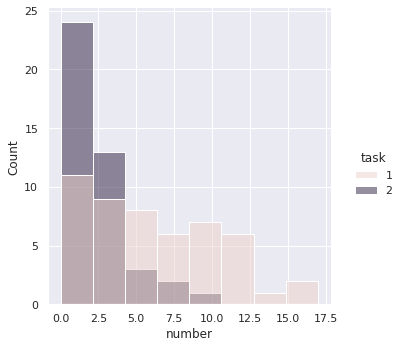

In [ ]:
sns.displot(data, x="number", hue="task")



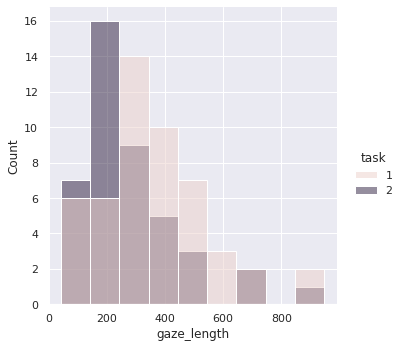

In [123]:
sns.displot(data, x="gaze_length", hue="task")

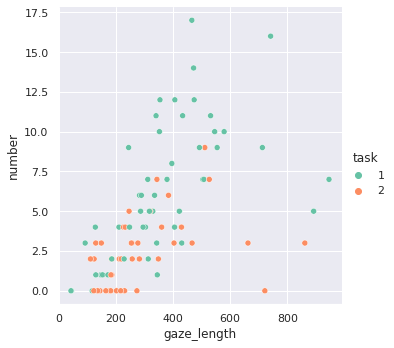

In [136]:
sns.relplot(data=data.reset_index(), x ="gaze_length", y="number", hue = "task", palette="Set2")

Total Videos 93


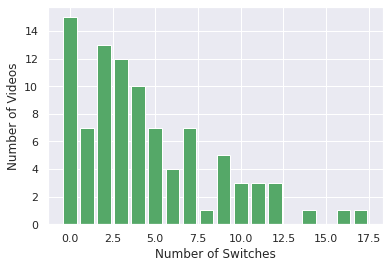

In [ ]:
d = defaultdict(lambda: 0)
for l in my_lists:
  d[len(l)] += 1
plt.bar(d.keys(), d.values(), color='g')
plt.xlabel('Number of Switches')
plt.ylabel('Number of Videos')
print("Total Videos", sum(d.values()))

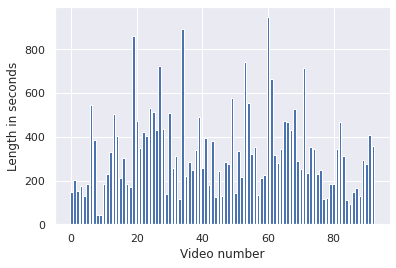

In [ ]:
fig, ax = plt.subplots()

# Example data
files = np.arange(0, len(labels_switches["file"].tolist()))
y_pos = labels_switches["gaze_length"].tolist()

ax.bar(files, y_pos)
ax.set_xlabel('Video number')
ax.set_ylabel('Length in seconds')

plt.show()